In [1]:
import matplotlib.pyplot as plt
from source.image_force import Force1, Force2, Force3
import cv2 as cv
from source.utils import normalization_automatic
import numpy as np

# Evaluation Energy Functions

In [2]:
initial_level_set = cv.imread('test_images/simplify_cells_distance_multiply_10.tif', cv.CV_8U)
initial_level_set = normalization_automatic(initial_level_set)
image = cv.imread('test_images/simplify_cells.tif', cv.CV_16U) 
image = normalization_automatic(image)

In [3]:
k0 = 1
k1 = 1
sigma = 1
force1 = Force1(image, k0=k0, k1=k1)
r1 = force1.compute_force(initial_level_set>0)
force2 = Force2(image)
r2 = force2.compute_force(initial_level_set>0)
force3 = Force3(image, k0=k0, k1=k1, sigma=sigma)
r3 = force3.compute_force(initial_level_set>0)


c:\Users\tania\OneDrive\Documentos\medical_image\medical-image-project\source\image_force.py:39: RuntimeWarning: divide by zero encountered in log
  return np.log(self.proba_in()) - np.log(self.proba_out())


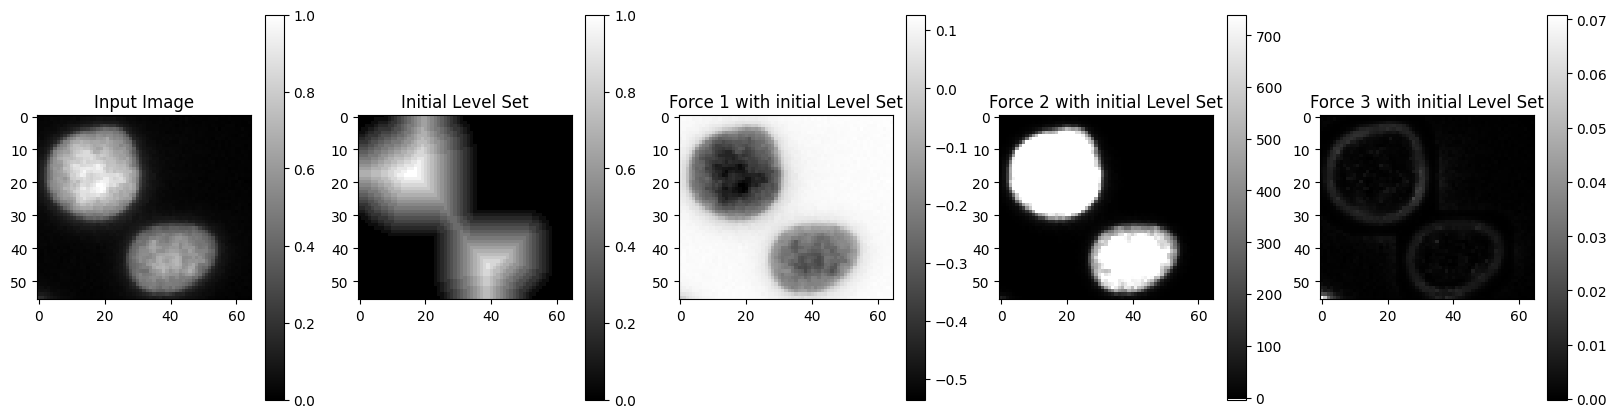

In [4]:
fig, ax = plt.subplots(1,5, figsize=(20,5))
ax[0].set_title('Input Image')
pos = ax[0].imshow(image, 'gray')
fig.colorbar(pos, ax=ax[0])

ax[1].set_title('Initial Level Set')
pos = ax[1].imshow(initial_level_set, 'gray')
fig.colorbar(pos, ax=ax[1])

ax[2].set_title('Force 1 with initial Level Set')
pos = ax[2].imshow(r1, 'gray')
fig.colorbar(pos, ax=ax[2])


ax[3].set_title('Force 2 with initial Level Set')
pos = ax[3].imshow(r2, 'gray')
fig.colorbar(pos, ax=ax[3])


ax[4].set_title('Force 3 with initial Level Set')
pos = ax[4].imshow(r3, 'gray')
fig.colorbar(pos, ax=ax[4])
plt.show()



## Force 3

The formulation of this force is the following:
\begin{equation}
r_3 = \kappa_1\int K_{\sigma}(y-x) |I(x) - f_1(y)|^2 dy - \kappa_0\int K_{\sigma}(y-x) |I(x) - f_0(y)|^2 dy
\end{equation}

where $K_{\sigma}(u) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{|u|^2}{2\sigma^2}}$ is a Gaussian Kernel and the functions $f_0$ and $f_1$ are the inside and outside approximation of the the image centered at each point. Defined by:
\begin{align}
f_0 = \frac{K_\sigma(x) * [(1 - H(\phi(x))) I(x)]}{K_\sigma(x) * [1 - H(\phi(x))]}\\ 
f_1 = \frac{K_\sigma(x) * [H(\phi(x)) I(x)]}{K_\sigma(x) * H(\phi(x))}
\end{align}

For simplicity, in the code we removed the use of Heaviside function by using masks.

Let's consider $M_{in}$ the image mask which is one when we are inside the region and $M_{out}$ the image mask which is one when we are outside the region. Given this difiniation we can define: $I_{in}$ and $I{out}$ their respective masked images.

We can rewrite the equations $f_{in}$($f_1$) and $f_{out}$($f_0$) as:
\begin{align}
f_{in} &= \frac{K_\sigma(x) *I_{in}(x)}{K_\sigma(x) * M_{in}(x)}\\ 
f_{out} &= \frac{K_\sigma(x) *I_{out}(x)}{K_\sigma(x) * M_{out}(x)}
\end{align}

The convolution on the denominator will be always its corresponding mask, because $M_{in}$ and $M_{out}$ are arrays with only 0 and 1. Then, we can rewrite:
\begin{align}
f_{in} &= K_\sigma(x) *I_{in}(x)\\ 
f_{out} &= K_\sigma(x) *I_{out}(x)
\end{align}


Then the force could be define as:
\begin{align}
r_3(x) &= \kappa_1 \sum_{y \in interior } K_{\sigma}(y-x) |I(x) - f_{in}(y)|^2 - \kappa_0 \sum_{y \in outside} K_{\sigma}(y-x) |I(x) - f_{out}(y)|^2\\
r_3(x) &= \kappa_1 \sum_{y \in interior } K_{\sigma}(y-x) [I^2(x) -2I(x)f_{in}(y) +f_{in}^2(y)] - \kappa_0 \sum_{y \in outside} K_{\sigma}(y-x) [I^2(x) - 2 I(x) f_{out}(y) + f_{out}^2(y)]\\
r_3(x) &= (\kappa_1 - \kappa_0) \sum_{y \in image } K_{\sigma}(y-x) I^2(x) - 2\kappa_1 I(x) \sum_{y \in inside}K_{\sigma}(y-x)f_{in}(y) + 2\kappa_0 I(x) \sum_{y \in outside} K_{\sigma}(y-x)f_{out}(y) + \kappa_1 \sum_{y \in inside} K_{\sigma}(y-x)f_{in}^2(y) - \kappa_0 \sum_{y \in outside} K_{\sigma}(y-x)f_{out}^2(y) \\
r_3(x) &= (\kappa_1 - \kappa_0)  (K_{\sigma} * I^2) (x) -  2\kappa_1 I(x) [(K_{\sigma} * f_{in})(x)] + 2\kappa_0 I(x) [(K_{\sigma} * f_{out})(x)] + \kappa_1 (K_{\sigma} * f_{in}^2)(x) - \kappa_0 (K_{\sigma} * f_{out}^2)(x) 
\end{align}

In the usual definition of Gaussian Kernel, we have two parameters `kernel_size` and `sigma`. However, in the articles the authors consider only sigma and they afirm that sigma control the size of the region in which the image intensities are approximated. Taking this into consideration, in our implementation, we decide that  `kernel_size = (2*sigma+1, 2*sigma+1)`, to obtain a valid kernel size for every sigma (it has to be an integer).



### Local Function Approximation

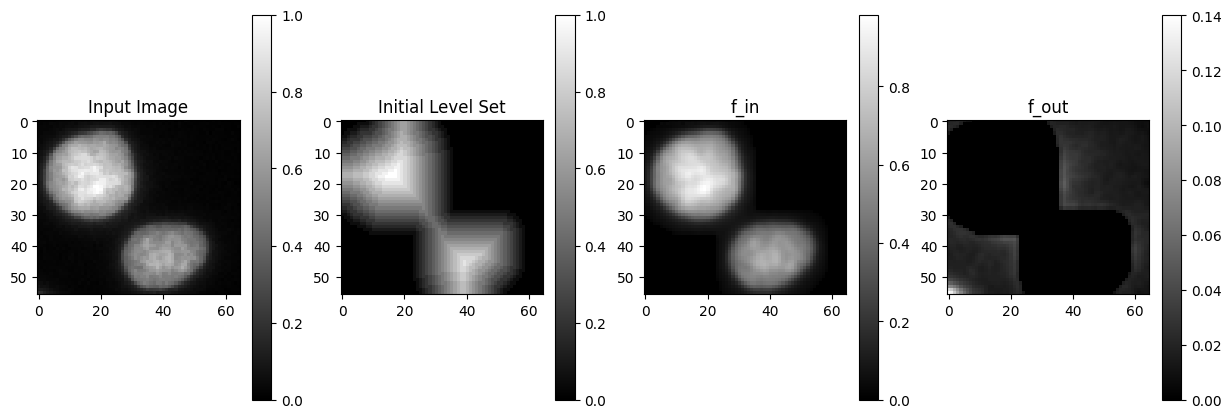

In [5]:
f_in = force3.f_in()
f_out = force3.f_out()
fig, ax = plt.subplots(1,4, figsize=(15,5))

ax[0].set_title('Input Image')
pos = ax[0].imshow(image, 'gray')
fig.colorbar(pos, ax=ax[0])

ax[1].set_title('Initial Level Set')
pos = ax[1].imshow(initial_level_set, 'gray')
fig.colorbar(pos, ax=ax[1])

ax[2].set_title('f_in')
pos = ax[2].imshow(f_in, 'gray')
fig.colorbar(pos, ax=ax[2])

ax[3].set_title('f_out')
pos = ax[3].imshow(f_out, 'gray')
fig.colorbar(pos, ax=ax[3])

**Observation**

Visually the aproximation for the interior seems to be coherent. However, the approximation for the outside of the level set has a little artifact at the left corner that is probably an border artifact.

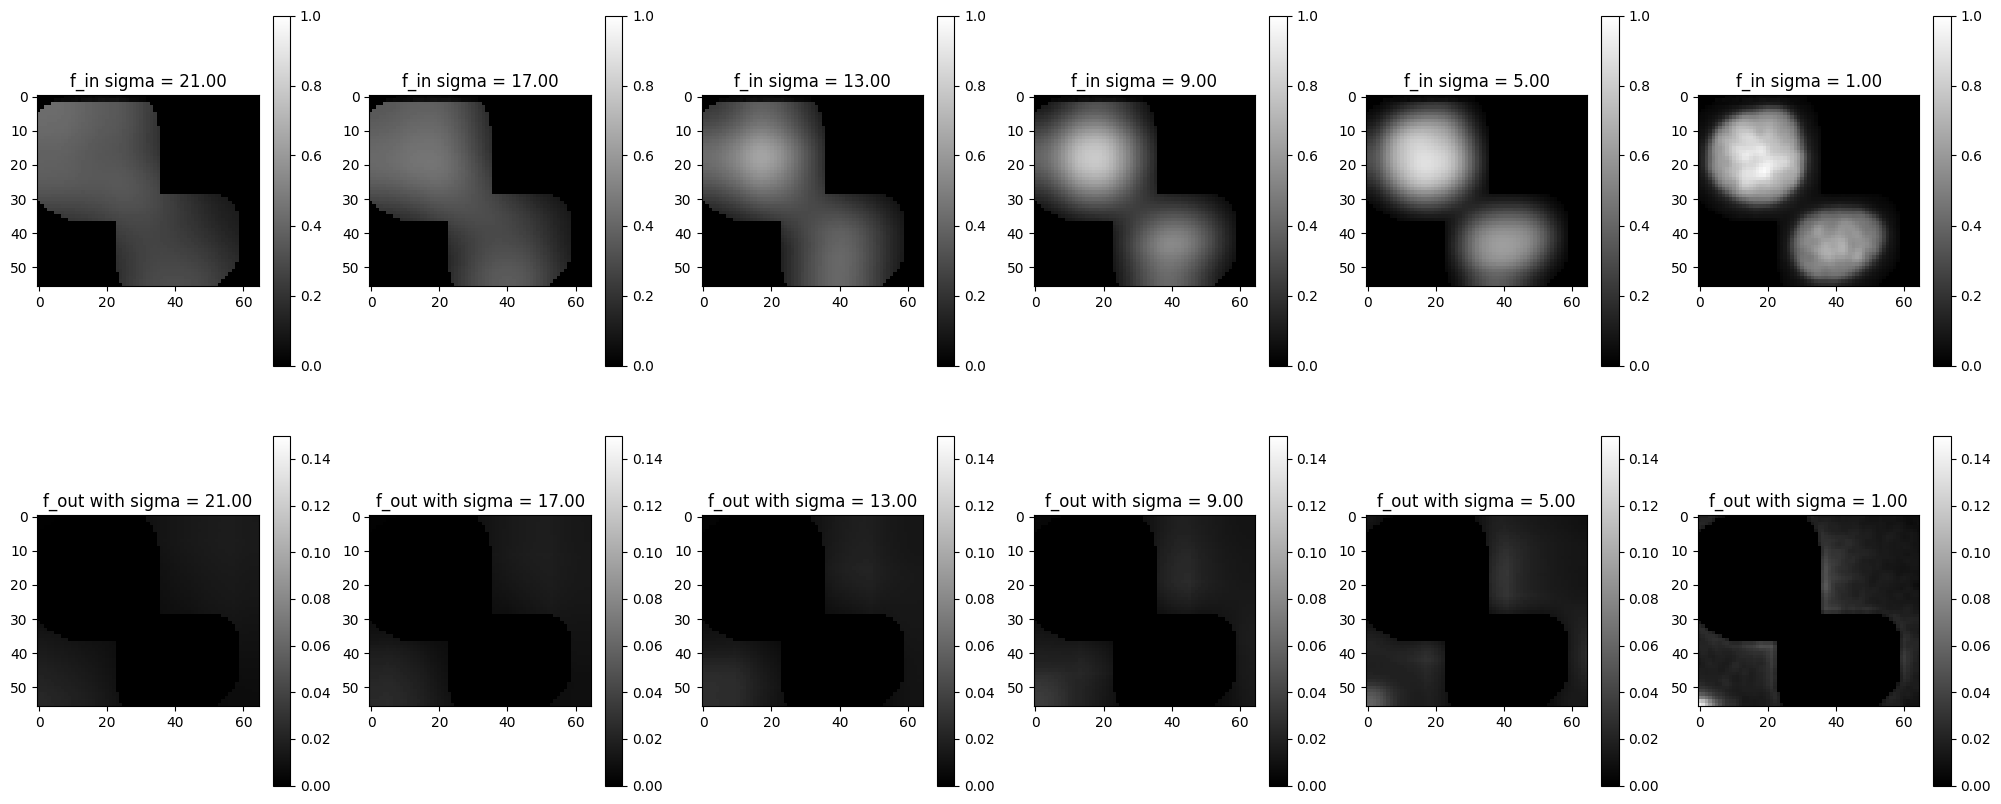

In [13]:
sigma_list = np.arange(1, 25, 4)
vmin_r3, vmax_r3 = 0, 1
vmin_out, vmax_out = 0, .15
N = len(sigma_list)
fig, ax = plt.subplots(2,N, figsize=(5*(N-1),10))
for i, sigma in enumerate(sigma_list[::-1]):
    force3 = Force3(image, k0=k0, k1=k1, sigma=sigma)
    _ = force3.compute_force(initial_level_set>0)
    f_in = force3.f_in()
    f_out = force3.f_out()

    ax[0, i].set_title(f'f_in sigma = {sigma:.2f}')
    pos = ax[0, i].imshow(f_in, 'gray', vmin=vmin_r3, vmax=vmax_r3)
    fig.colorbar(pos, ax=ax[0, i])

    ax[1, i].set_title(f'f_out with sigma = {sigma:.2f}')
    pos = ax[1, i].imshow(f_out, 'gray', vmin=vmin_out, vmax=vmax_out)
    fig.colorbar(pos, ax=ax[1, i])

    if np.min(f_in) < vmin_r3 or np.max(f_in) > vmax_r3:
        print(f'Visualization error!! The selected vmin and vmax for the region inside are not valid') 
    if np.min(f_out) < vmin_out or np.max(f_out) > vmax_r3:
        print(f'Visualization error!! The selected vmin and vmax for the region outside are not valid')
    




**Observation**

As we expected, when we lower the parameter $\sigma$ our functions $f_{in}$ and $f_{out}$ are a more local approximation. Then when we lower $\sigma$ parameter $f_{in} + f_{out} \approx I$



### Evolution of the force

If we consider $k_1 = k_2$ as they do in the paper. Using convolution properties we can rewrite the force like:
\begin{align}
r_3(x) &= -  2\kappa I(x) [(K_{\sigma} * f_{in})(x)] + 2\kappa I(x) [(K_{\sigma} * f_{out})(x)] + \kappa (K_{\sigma} * f_{in}^2)(x) - \kappa (K_{\sigma} * f_{out}^2)(x) \\
r_3(x) &= -  2\kappa I(x) [(K_{\sigma} * (f_{in}-f_{out})(x)] + \kappa (K_{\sigma} * (f_{in}^2 + f_{out}^2))(x)
\end{align}


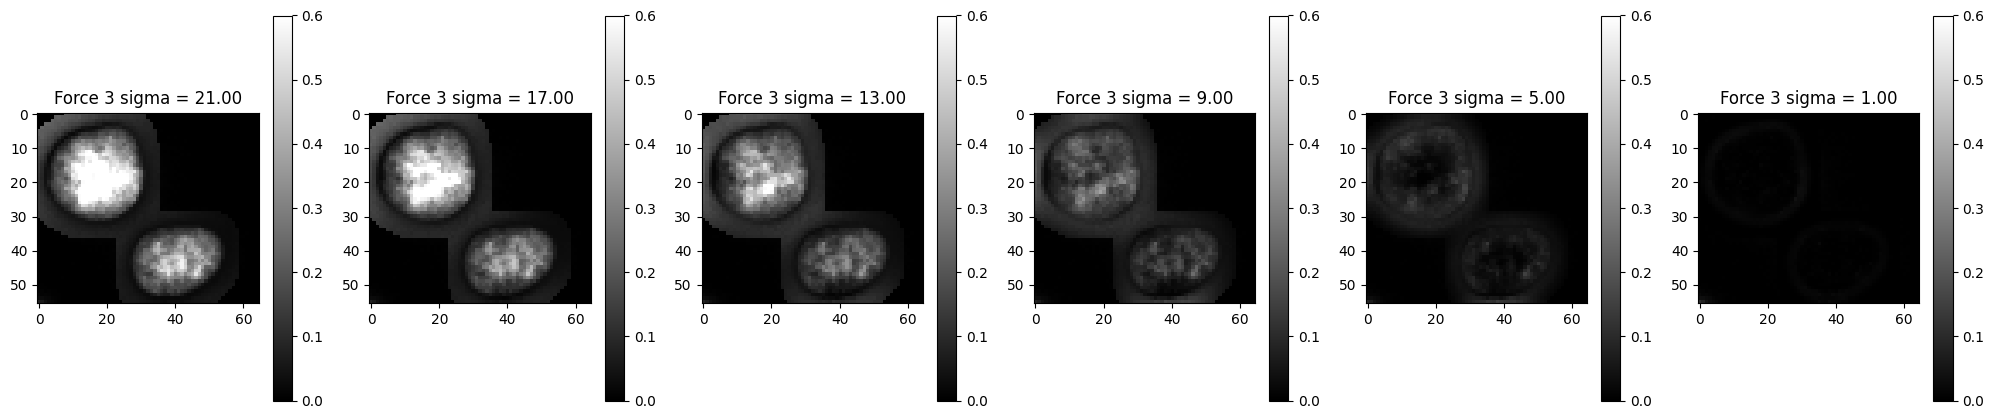

In [44]:
vmin_r3, vmax_r3 = 0, 0.6
fig, ax = plt.subplots(1,N, figsize=(5*(N-1),5))
for i, sigma in enumerate(sigma_list[::-1]):
    force3 = Force3(image, k0=k0, k1=k1, sigma=sigma)
    r3 = force3.compute_force(initial_level_set>0)
    
    ax[i].set_title(f'Force 3 sigma = {sigma:.2f}')
    pos = ax[i].imshow(r3, 'gray', vmin=vmin_r3, vmax=vmax_r3)
    fig.colorbar(pos, ax=ax[i])

**Observation**

In our current case the region outside is practically zero, so ONLY in this example $f_{in} - f_{out}\approx I$ for lower values of $\sigma$, which means we are getting values similar to zero in our force.